<a href="https://colab.research.google.com/github/danielabebe1/CapstoneProject1/blob/master/Copy_of_Copy_of_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project I

## Predicting Pain Relievers 

Both prescribed and non-prescribed use of pain relievers, as well as rates of opioid-related mortality and admissions to emergency departments, have increased in the last few years. There is no exact figure on how many people are affected by this problem but the number has increased according to ‘National Center for Biotechnology Information’. There are many different pain relievers, and each one has advantages and risks. Some types of pain respond better to certain medicines than others. Each person has a different response to a pain reliever for the same type of condition. This is mainly because the conditions that cause pain are very complicated, which is one of the reasons why pain management is so difficult. This difficulty decreases the quality of life of patients that, in many cases, can suffer from constant pain with little to no relief. General-purpose pain-relieving medication is often ineffective even the best painkiller like morphine can sometimes fail to inhibit pain in cancer patients. Painkillers are working by activating a receptor cell call REV_ERBs that sends chemical signals inside the cell to block the production of certain genes regulates pain-causing and inflammatory molecules inside the body. The goal of this project is to build a model that can predict painkiller selected conditions and for different age groups. 
The possible stakeholders of this project includes pharmaceutical companies, physicians and clinicians, insurance companies and patients. Knowing the consumers’ response for the product is crucial in many majors in addition to the available research and development in the field will help physicians and clinicians while subscribing to these drugs. Pharmaceutical companies and insurance companies will also identify their focus drugs for their consumers. 
The dataset used in this project was acquired from kaggle where uploaded on kaggle by scraping the WebMD site (https://www.kaggle.com/rohanharode07/webmd-drug-reviews-dataset). The dataset provides user reviews on specific drugs along with related conditions, side effects, age, sex, and ratings reflecting overall patient satisfaction. The dataset contains 12 features with mixed variables including categorical, numerical and date. There are above 360 thousands of rows of unique reviews and are updated till Mar 2020.


In [1]:
#Importing the relevant libraries and load the data into the data frameles
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set
from scipy.stats import ttest_ind,randint
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, metrics
from sklearn import utils
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/webmd.csv'
#the dataset is in csv format so we'll use read_csv function in pandas and replace blank space with NaN by "na_values=' '"
df=pd.read_csv(path, na_values=' ')

Mounted at /content/drive


In [3]:
#Only some attributes are considered in this project we'll drop attributes that aren't considered.
df=df.drop(['Date', 'DrugId', 'Reviews', 'Sides', 'UsefulCount'], axis=1)

#Since our focus to predict painkiller, we'll chose conditions that have a word pain in them 
df=df[df.Condition.str.contains('Pain', na=False)]

#check the number of features and rows of remaining data
print("Dataset contains: " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns")

#display top 5 rows
df.Condition.value_counts().head(5)

Dataset contains: 53649 rows and 7 columns


Pain                                                         25232
Neuropathic Pain                                              8988
Disorder characterized by Stiff, Tender & Painful Muscles     3472
Chronic Pain                                                  2913
Joint Damage causing Pain and Loss of Function                2451
Name: Condition, dtype: int64

For this project let's use one condition that is frequently occured in the dataset. Looking at the value_counts() above the top condition is 'Pain' but it is very general so we chose Neuropathic Pain for our model. 

In [5]:
df=df[df['Condition']=='Neuropathic Pain']
df.Drug.value_counts().head()

lyrica                 1283
neurontin               790
neurontin capsule       790
cymbalta                699
gabapentin solution     661
Name: Drug, dtype: int64

We merged drugs in one family for instance 'tramadol hcl' and 'tramadol hcl er' are the same chemical composition with minor difference.

In [6]:
df.replace(to_replace=['gabapentin tablet, extended release 24 hr','gabapentin solution','neurontin capsule', 'oxycodone tablet, oral only',
                       'oxycodone hcl er','oxycodone hcl','oxycodone hcl solution', 'tramadol hcl','tramadol hcl er','methadone hcl',
                       'methadone hcl tablet, soluble','methadone hcl solution', 'morphine sulfate er tablet, extended release', 
                       'morphine sulfate', 'morphine sulfate er capsule, extended release multiphase 24 hr',
                       'morphine tablet,oral only, extended release','morphine sulfate er'], 
           value=['gabapentin','gabapentin','neurontin','oxycodone','oxycodone','oxycodone','oxycodone',
                 'tramadol','tramadol','methadone','methadone','methadone','morphine','morphine','morphine','morphine',
                  'morphine'], inplace=True)

In [7]:
df.Drug.value_counts().head(7)

gabapentin           1983
oxycodone            1608
neurontin            1580
lyrica               1283
cymbalta              699
tramadol              654
amitriptyline hcl     240
Name: Drug, dtype: int64

In [8]:
#Let's chose top four drugs with high frequency
df=df[df['Drug'].isin(['gabapentin','oxycodone','neurontin','lyrica'])]
df.Condition.value_counts()

Neuropathic Pain    6454
Name: Condition, dtype: int64

In [9]:
#check if there are missing values
print('Do null values exist in the dataset? ' + str(df.isnull().values.any()))
#fill missing values using method 'pad' and drop if there are any unfilled null values using pad method
df.fillna(method ='pad', inplace=True) 
df.dropna(inplace=True)
#check agin missing values
print('Do null values exist in the dataset? ' + str(df.isnull().values.any()))


Do null values exist in the dataset? True
Do null values exist in the dataset? False


# Exploratory Data Analysis

In this section we try to visualize and statistically hypothesize to understand the dataset better and and the best way to represent it to actually gain meaningful insights.  

In [10]:
# Feature engineering: discretization on age for age_group & age_bin_label
# before getting into grouping, lets replace the existing group to approximate age. 
df.replace(to_replace=['0-2', '3-6','7-12', '13-18','19-24','25-34','35-44','45-54','55-64','65-74','75 or over'], 
           value=[0,5,10,15,20,30,40,50,60,70,80], inplace=True)

age_bins = [0, 20, 30, 40, 50, 60, 70,80]
age_bin_labels = [1,2,3,4,5,6,7]
# Stratification: age_group, Generate age_group and age_group_label
df['Age_group'] = pd.cut(np.array(df['Age']),bins=age_bins) 
df['Age_group_label'] = pd.cut(np.array(df['Age']),bins=age_bins, labels=age_bin_labels) 

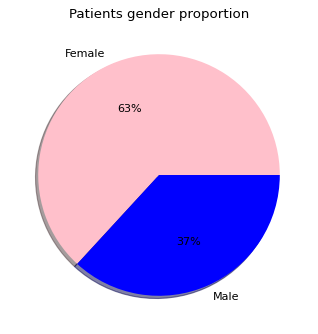

In [11]:
# Count frequencies and shows patients breakdown by stroke condition:
df_sex = pd.DataFrame(df.groupby('Sex')['Sex'].count())
df_sex.columns = ['count']
plt.figure(figsize=(6,5), dpi= 80)
plt.pie(df_sex, labels=['Female','Male'], autopct='%.0f%%', colors=['pink','blue'], shadow=True)
plt.title('Patients gender proportion')
plt.show()

Text(0.5, 1.0, 'Age distribution')

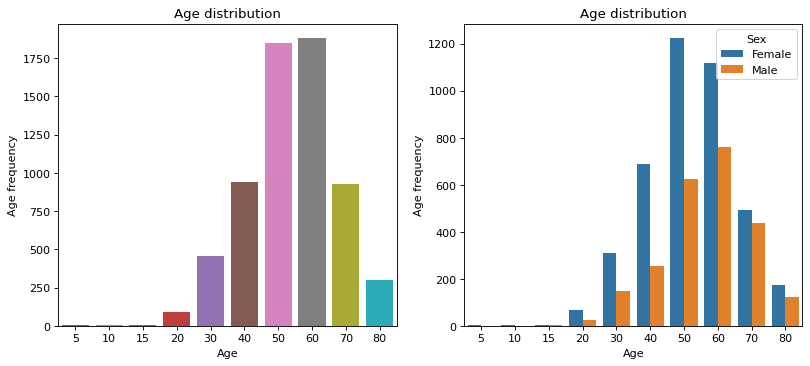

In [12]:
#visualize age distribution of the patient 
plt.figure(figsize=(12,5), dpi= 80)
plt.subplot(1, 2, 1)
sns.countplot(x="Age", data=df,);
plt.ylabel('Age frequency')
plt.title('Age distribution')
plt.subplot(1, 2, 2)
sns.countplot(x="Age", hue="Sex",data=df,);
plt.ylabel('Age frequency')
plt.title('Age distribution')
# plt.subplot(1, 3, 2)
# sns.countplot(x="Effectiveness", hue="Sex",data=df);
# plt.subplot(1, 3, 3)
# sns.countplot(x="Satisfaction", hue="Sex",data=df);

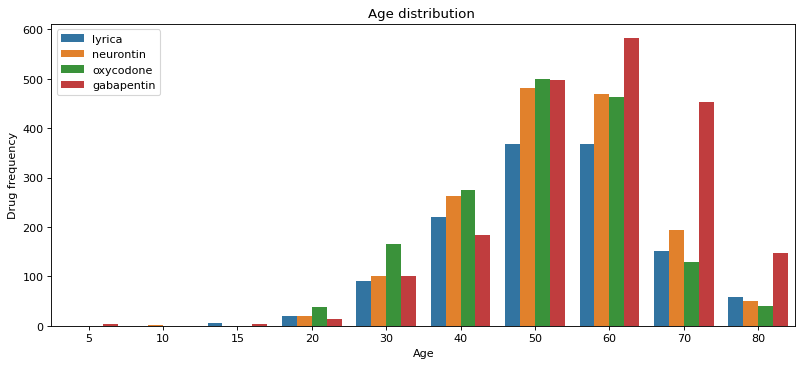

In [13]:
#The frequency of selected drugs across age.
plt.figure(figsize=(12,5), dpi= 80)

sns.countplot(x="Age", hue="Drug",data=df,);
plt.ylabel('Drug frequency')
plt.title('Age distribution ')
plt.legend(loc='upper left')

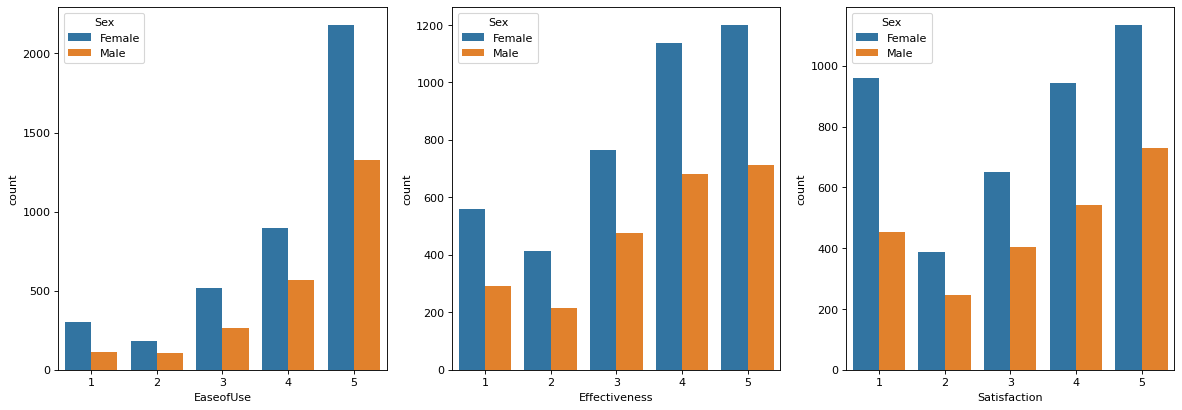

In [14]:
plt.figure(figsize=(18,6), dpi= 80)
plt.subplot(1, 3, 1)
sns.countplot(x="EaseofUse", hue="Sex",data=df,);
plt.subplot(1, 3, 2)
sns.countplot(x="Effectiveness", hue="Sex",data=df);
plt.subplot(1, 3, 3)
sns.countplot(x="Satisfaction", hue="Sex",data=df);

Text(0.5, 1.0, 'Frequency of Drug')

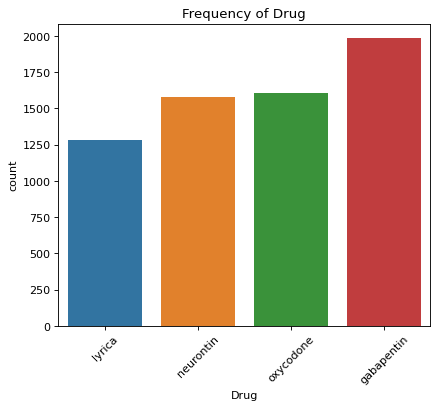

In [15]:
plt.figure(figsize=(6,5), dpi= 80)
av=sns.countplot(x="Drug", data=df,);
av.set_xticklabels(av.get_xticklabels(), rotation=45);
av.set_title('Frequency of Drug')


In [16]:
df_mean=df.groupby('Age').mean()
df_mean

,EaseofUse,Effectiveness,Satisfaction
Age,,,
5,5.000000,5.000000,5.000000
10,3.000000,4.000000,3.000000
15,4.750000,3.625000,3.375000
20,3.820225,3.505618,3.258427
30,4.026258,3.527352,3.236324
40,4.161359,3.537155,3.249469
50,4.126623,3.550325,3.287338
60,4.194681,3.565426,3.375532
70,4.110991,3.368534,3.134698


<Figure size 480x400 with 0 Axes>

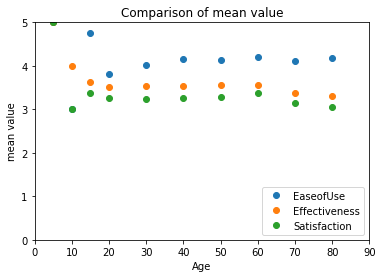

In [17]:
plt.figure(figsize=(6,5), dpi= 80)
df_mean.plot(style='o')
# Plot formatting
plt.xlabel('Age')
plt.ylabel('mean value')
plt.xlim(0,90)
plt.ylim(0,5)
plt.title('Comparison of mean value')
plt.legend(loc='lower right')

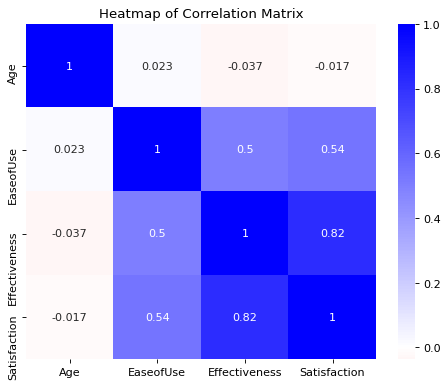

In [18]:
#graphical representation of corellation
plt.figure(figsize=(6,5), dpi= 80)
hm=sns.heatmap(df.corr(), annot=True,center = 0,cmap='bwr_r', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()

In [19]:
# Filter dataframe by a target label
df_gab=df[df['Drug']=='gabapentin']
df_oxy=df[df['Drug']=='oxycodone']
df_neu=df[df['Drug']=='neurontin']
df_lyr=df[df['Drug']=='lyrica']
# Stratified by age_group_label of oxycodone drug:
df_oxy_grp1 = df_oxy[df_oxy['Age_group_label'] == 1] # age: <20 
df_oxy_grp2 = df_oxy[df_oxy['Age_group_label'] == 2] # age: 20-30
df_oxy_grp3 = df_oxy[df_oxy['Age_group_label'] == 3] # age: 30-40
df_oxy_grp4 = df_oxy[df_oxy['Age_group_label'] == 4] # age: 40-50
df_oxy_grp5 = df_oxy[df_oxy['Age_group_label'] == 5] # age: 50-60
df_oxy_grp6 = df_oxy[df_oxy['Age_group_label'] == 6] # age: 60-70
df_oxy_grp7 = df_oxy[df_oxy['Age_group_label'] == 7] # age: >70

# Stratified by age_group_label of neurontin drug: 
df_neu_grp1 = df_neu[df_neu['Age_group_label'] == 1] 
df_neu_grp2 = df_neu[df_neu['Age_group_label'] == 2] 
df_neu_grp3 = df_neu[df_neu['Age_group_label'] == 3] 
df_neu_grp4 = df_neu[df_neu['Age_group_label'] == 4] 
df_neu_grp5 = df_neu[df_neu['Age_group_label'] == 5] 
df_neu_grp6 = df_neu[df_neu['Age_group_label'] == 6] 
df_neu_grp7 = df_neu[df_neu['Age_group_label'] == 7] 

# Stratified by age_group_label of lyrica drug:
df_lyr_grp1 = df_lyr[df_lyr['Age_group_label'] == 1]  
df_lyr_grp2 = df_lyr[df_lyr['Age_group_label'] == 2] 
df_lyr_grp3 = df_lyr[df_lyr['Age_group_label'] == 3] 
df_lyr_grp4 = df_lyr[df_lyr['Age_group_label'] == 4] 
df_lyr_grp5 = df_lyr[df_lyr['Age_group_label'] == 5] 
df_lyr_grp6 = df_lyr[df_lyr['Age_group_label'] == 6] 
df_lyr_grp7 = df_lyr[df_lyr['Age_group_label'] == 7] 

# Age group counts index for stratification by major class "drug" %:
df_gab_counts = df_gab[['Age_group','Age_group_label']]
df_gab_counts = pd.DataFrame(df_gab_counts.groupby('Age_group_label')['Age_group'].count())
df_gab_counts.columns = ['counts']

# Compute age group label proporiton % on gabapentin drug:
df_gab_counts['Age_group_pct'] = df_gab_counts['counts']/df_gab_counts['counts'].sum()

# Print the count index for each age group from gabapentin drug:
print(df_gab_counts)

                 counts  Age_group_pct
Age_group_label                       
1                    19       0.009581
2                   100       0.050429
3                   184       0.092789
4                   498       0.251135
5                   582       0.293495
6                   453       0.228442
7                   147       0.074130


In [20]:
# Upsampling on oxycodone drug by gabapentin drug proporition %

sampled_oxy_grp1 = resample(df_oxy_grp1, replace=True, n_samples=20,random_state=0)
sampled_oxy_grp2 = resample(df_oxy_grp2, replace=True, n_samples=100,random_state=0)
sampled_oxy_grp3 = resample(df_oxy_grp3, replace=True, n_samples=185,random_state=0)
sampled_oxy_grp4 = resample(df_oxy_grp4, replace=True, n_samples=500,random_state=0)
sampled_oxy_grp5 = resample(df_oxy_grp5, replace=True, n_samples=580,random_state=0)
sampled_oxy_grp6 = resample(df_oxy_grp6, replace=True, n_samples=455,random_state=0)
sampled_oxy_grp7 = resample(df_oxy_grp7, replace=True, n_samples=150,random_state=0)

# Concatentate upsampled minority class: "oxycodone" drug of all age groups
df_oxy_upsampled = pd.concat([sampled_oxy_grp1,sampled_oxy_grp2,sampled_oxy_grp3, sampled_oxy_grp4,sampled_oxy_grp5,sampled_oxy_grp6,
                              sampled_oxy_grp7], axis=0)

In [21]:
# Upsampling on neurontin drug by gabapentin drug proporition %

sampled_neu_grp1 = resample(df_neu_grp1, replace=True, n_samples=20,random_state=0)
sampled_neu_grp2 = resample(df_neu_grp2, replace=True, n_samples=100,random_state=0)
sampled_neu_grp3 = resample(df_neu_grp3, replace=True, n_samples=185,random_state=0)
sampled_neu_grp4 = resample(df_neu_grp4, replace=True, n_samples=500,random_state=0)
sampled_neu_grp5 = resample(df_neu_grp5, replace=True, n_samples=580,random_state=0)
sampled_neu_grp6 = resample(df_neu_grp6, replace=True, n_samples=455,random_state=0)
sampled_neu_grp7 = resample(df_neu_grp7, replace=True, n_samples=150,random_state=0)

# Concatentate upsampled minority class: "neurontin" drug of all age groups
df_neu_upsampled = pd.concat([sampled_neu_grp1,sampled_neu_grp2,sampled_neu_grp3, sampled_neu_grp4,sampled_neu_grp5,sampled_neu_grp6,
                               sampled_neu_grp7], axis=0)

In [22]:
# Upsampling on lyrica drug by gabapentin drug proporition %

sampled_lyr_grp1 = resample(df_lyr_grp1, replace=True, n_samples=20,random_state=0)
sampled_lyr_grp2 = resample(df_lyr_grp2, replace=True, n_samples=100,random_state=0)
sampled_lyr_grp3 = resample(df_lyr_grp3, replace=True, n_samples=185,random_state=0)
sampled_lyr_grp4 = resample(df_lyr_grp4, replace=True, n_samples=500,random_state=0)
sampled_lyr_grp5 = resample(df_lyr_grp5, replace=True, n_samples=580,random_state=0)
sampled_lyr_grp6 = resample(df_lyr_grp6, replace=True, n_samples=455,random_state=0)
sampled_lyr_grp7 = resample(df_lyr_grp7, replace=True, n_samples=150,random_state=0)

# Concatentate upsampled minority class: "lyrica" drug of all age groups
df_lyr_upsampled = pd.concat([sampled_lyr_grp1,sampled_lyr_grp2,sampled_lyr_grp3, sampled_lyr_grp4,sampled_lyr_grp5,sampled_lyr_grp6,
                              sampled_lyr_grp7], axis=0)

# Conbine upsampled minority classes: "oxycodone,neurontin,lyrica" drug with upsampled gabapentin drug
df = pd.concat([df_oxy_upsampled,df_neu_upsampled,df_lyr_upsampled,df_gab],axis=0)

In [23]:
#reset index
df.reset_index(drop=True, inplace=True)
#pickle dataframe for later use
df.to_pickle("Neuropathic Pain.pkl")
#Let's see the first 5 rows
df.head()

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Age_group,Age_group_label
0,20,Neuropathic Pain,oxycodone,1,1,1,Female,"(0, 20]",1
1,20,Neuropathic Pain,oxycodone,4,4,4,Male,"(0, 20]",1
2,20,Neuropathic Pain,oxycodone,4,4,4,Male,"(0, 20]",1
3,20,Neuropathic Pain,oxycodone,3,3,4,Female,"(0, 20]",1
4,20,Neuropathic Pain,oxycodone,5,5,5,Female,"(0, 20]",1


In [24]:
import pickle
path='/content/Neuropathic Pain.pkl'
df=pd.read_pickle(path)
df.head()

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Age_group,Age_group_label
0,20,Neuropathic Pain,oxycodone,1,1,1,Female,"(0, 20]",1
1,20,Neuropathic Pain,oxycodone,4,4,4,Male,"(0, 20]",1
2,20,Neuropathic Pain,oxycodone,4,4,4,Male,"(0, 20]",1
3,20,Neuropathic Pain,oxycodone,3,3,4,Female,"(0, 20]",1
4,20,Neuropathic Pain,oxycodone,5,5,5,Female,"(0, 20]",1


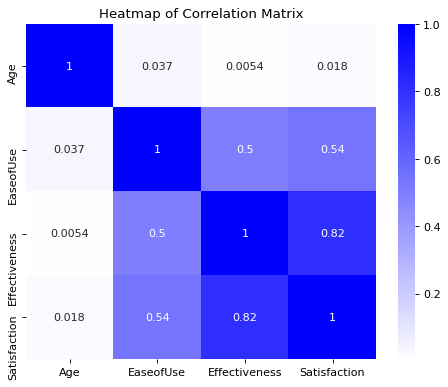

In [25]:
#graphical representation of corellation
plt.figure(figsize=(6,5), dpi= 80)
hm=sns.heatmap(df .corr(), annot=True,center = 0,cmap='bwr_r', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()

# Statistical Test

#### Impact of EaseofUse and Satisfaction

Paired sampled t-test :- The paired sample t-test is also called dependent sample t-test. It’s an uni variate test that tests for a significant difference between 2 related variables.

Hypothesis Testing:  Is there significant difference between the patients response towards EaseofUse and Satisfaction?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{EaseofUse} = \rho_{Satisfaction}
\end{array}

The null hypothesis would be that there is no difference in patients response of EaseofUse and Satisfaction:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{EaseofUse} \neq \rho_{Satisfaction}
\end{array}


The alternative hypothesis would be that there is a difference in patients response of EaseofUse and Satisfaction.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [26]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df['EaseofUse'], df['Satisfaction'])
print(ttest,pval)
if pval < 0.05:
    print("fail to accepet null hypothesis")
else:
    print("accept null hypothesis")

40.6586087199659 0.0
fail to accepet null hypothesis


#### Impact of Effectiveness and Satisfaction

Hypothesis Testing:  Is there significant difference between the patients response towards Effectiveness and Satisfaction?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{Effectiveness} = \rho_{Satisfaction}
\end{array}

The null hypothesis would be that there is no difference in patients response of Effectiveness and Satisfaction:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{Effectiveness} \neq \rho_{Satisfaction}
\end{array}

The alternative hypothesis would be that there is a difference in patients response of Effectiveness and Satisfaction.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [27]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df['Effectiveness'], df['Satisfaction'])
print(ttest,pval)
if pval < 0.05:
    print("fail to accept null hypothesis")
else:
    print("accept null hypothesis")

11.317109888665783 1.4009999799830085e-29
fail to accept null hypothesis


#### Impact of EaseofUse and Effectiveness

Hypothesis Testing:  Is there significant difference between the patients response towards EaseofUse and Effectiveness?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{EaseofUse} = \rho_{Effectiveness}
\end{array}

The null hypothesis would be that there is no difference in patients response of EaseofUse and Effectiveness:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{EaseofUse} \neq \rho_{Effectiveness}
\end{array}

The alternative hypothesis would be that there is a difference in patients response of EaseofUse and Effectiveness.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [28]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df['EaseofUse'], df['Effectiveness'])
print(ttest,pval)
if pval < 0.05:
  print("fail to accept null hypothesis")
else:
  print("accept null hypothesis")

30.797822502772792 2.334344815019319e-202
fail to accept null hypothesis


#### Impact of Age and Satisfaction

Hypothesis Testing:  Is there significant difference between the patients response towards Age and Satisfaction?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{Age} = \rho_{Satisfaction}
\end{array}

The null hypothesis would be that there is no difference in patients response of Age and Satisfaction:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{Age} \neq \rho_{Satisfaction}
\end{array}

The alternative hypothesis would be that there is a difference in patients response of Age and Satisfaction.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [29]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df['Age'], df['Satisfaction'])
print(ttest,pval)
if pval < 0.05:
  print("fail to accept null hypothesis")
else:
  print("accept null hypothesis")

367.2134476748819 0.0
fail to accept null hypothesis


### Multicollinearity
Multicollinearity refers to predictors that are correlated with other predictors. Multicollinearity occurs when model includes multiple factors that are correlated not just to the response variable, but also to each other. In other words, it results when we have factors that are a bit redundant. Sklearn does not have a built-in way to check for multicollinearity


In [30]:
# Here's the relevant module
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity
# since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = df[['Age','EaseofUse','Effectiveness','Satisfaction']]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns
vif

,VIF,Features
0,9.113766,Age
1,15.852152,EaseofUse
2,23.313341,Effectiveness
3,18.253835,Satisfaction


Looking at the result of variance inflation factor, all numerical features have high multicolinearity. However, the VIF of Effectiveness is highest, so we will remove it from the model.

In [31]:
#drop effectiveness
df = df.drop(['Effectiveness'],axis=1)
#display new dataframe
df.head()

,Age,Condition,Drug,EaseofUse,Satisfaction,Sex,Age_group,Age_group_label
0,20,Neuropathic Pain,oxycodone,1,1,Female,"(0, 20]",1
1,20,Neuropathic Pain,oxycodone,4,4,Male,"(0, 20]",1
2,20,Neuropathic Pain,oxycodone,4,4,Male,"(0, 20]",1
3,20,Neuropathic Pain,oxycodone,3,4,Female,"(0, 20]",1
4,20,Neuropathic Pain,oxycodone,5,5,Female,"(0, 20]",1


# **MACHINE LEARNING MODELING**

## Create dummy variable
To include the categorical data in the regression, let's create dummy variable encoding on nominal features using a very 'convenient method called: get_dummies' which does that seemlessly. It is extremely important that we drop one of the dummies, alternatively will introduce multicollinearity.

In [32]:
df2 = pd.get_dummies(df[['Age','EaseofUse','Satisfaction','Sex']], drop_first=True)

# Concatenated with a Drug label on transformed dataframe: 
df = pd.concat([df2, df['Drug']], axis=1)

## Split input features and output label
Using split_train_test function partition original data into training and test sets for training and evaluation of any machine learning modeling task.  
After partitioning the data, we feature scale, the features to re-scale them into a similar range on each feature using scaler function.


In [33]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
#encoding the categical classes using label encoder
lab_enc = preprocessing.LabelEncoder()
y=lab_enc.fit_transform(y)
y = y.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

## **Data Modeling**

We modeled the data using different classification: Decission Tree, Random Forest, Gradient Boosting, XGBoosting, Extra tree and KNeighbors classifiers and the best model performance out of six will be selected.  

#### Tune Hyperparameters for Classification
Machine learning algorithms have hyperparameters that allow us to tailor the behavior of the algorithm to your specific dataset. In order to find out the best hyperparameters, we modeled cross-validation on the training dataset and create hyperparameter options then selected the best hyperparameter.

### Logistic Regression
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1].

In [34]:
# Model: Logistic Regression
lr_cv = LogisticRegression(C=0.1,penalty='l2',random_state=0)
lr_cv.fit(X_train, y_train)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: LogisticRegression #
# Create hyperparameter options:
param_dist = dict(C=randint(2,100), penalty=['l1','l2'])
random_search = RandomizedSearchCV(estimator=lr_cv, param_distributions=param_dist, random_state=0, n_iter=100, cv=4)
random_search_lr = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', random_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', random_search_lr.best_estimator_.get_params()['C'])


Best Penalty: l2
Best C: 46


In [35]:
lr= LogisticRegression(C=46,penalty='l2',random_state=0)
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);

### Support vector machine

Support Vector Machine is used for both regression and classification tasks. In SVM algorithm is to find a hyperplane in an n-dimensional space(n: the number of features) that distinctly classifies the data points. Hyperplanes are decision boundaries that help classify the data points. 

In [ ]:
# Model: support vector machine
svm_cv = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, 
                                 random_state=0)
svm_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_svm = {"C": randint(1, 100),
                  "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
                  "gamma": ['scale', 'auto'],
                  "shrinking":[True, False],
                  }
random_search = RandomizedSearchCV(estimator=svm_cv, param_distributions=param_dist_svm, random_state=0, n_iter=100, cv=4)
random_search_svm = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best shrinking:', random_search_svm.best_estimator_.get_params()['shrinking'])
print('Best gamma:', random_search_svm.best_estimator_.get_params()['gamma'])
print('Best kernel:', random_search_svm.best_estimator_.get_params()['kernel'])
print('Best C:', random_search_svm.best_estimator_.get_params()['C'])

In [37]:
svm = SVC(C=94, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, random_state=0)
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);

### Decision Tree Classifier

Decision tree is a Supervised Machine Learning where the data is continuously split according to a certain parameter. Decision tree classifier: using the decision algorithm, we start at the tree root and split the data on the feature that results in the largest information gain (IG). In an iterative process, we can then repeat this splitting procedure at each child node until the leaves are pure.


In [ ]:
# Model: DecisionTree [cross-validated train set]
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=2, min_samples_leaf=2, random_state=0)
tree_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_dt = {"criterion": ["gini", "entropy"],
                  "max_depth": randint(10, 100),
                  "max_leaf_nodes": randint(10, 20),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10)}
random_search = RandomizedSearchCV(estimator=tree_cv, param_distributions=param_dist_dt, random_state=0, n_iter=100, cv=4)
random_search_dt = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_leaf_nodes:', random_search_dt.best_estimator_.get_params()['max_leaf_nodes'])
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])
print('Best criterion:', random_search_dt.best_estimator_.get_params()['criterion'])

Best min_samples_split: 8
Best min_samples_leaf: 8
Best max_leaf_nodes: 19
Best max_depth: 83
Best criterion: gini


 1) Satisfaction                   0.490499
 2) Age                            0.171873
 3) EaseofUse                      0.169652
 4) Sex_Male                       0.167975


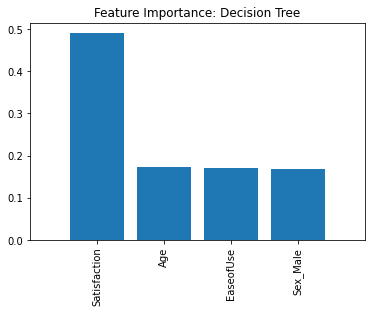

In [38]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=51, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=19,
                               random_state=0)
feat_labels = df.columns[:-1]
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,  feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importance: Decision Tree')
plt.bar(range(X_train.shape[1]), importances[indices],  align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### Random Forest Classifier

random forest is comprised of trees that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. 




In [ ]:
# Model: RandomForest [cross-validated and train set]
rf_cv = RandomForestClassifier(criterion='gini',n_estimators=50, max_depth=1, min_samples_split=2, random_state=0, n_jobs=1)
rf_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_rf = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(estimator=rf_cv, param_distributions=param_dist_rf, random_state=0, n_iter=100, cv=4)
random_search_rf = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best bootstrap:', random_search_rf.best_estimator_.get_params()['bootstrap'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

 1) Age                            0.399935
 2) EaseofUse                      0.261097
 3) Satisfaction                   0.258259
 4) Sex_Male                       0.080709


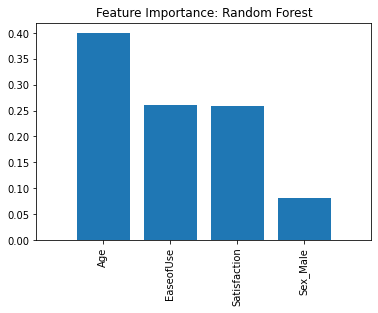

In [39]:
# Model prediction: Using a Random Forest:
rf = RandomForestClassifier(criterion='entropy', max_depth=33, min_samples_split=6, min_samples_leaf=2, n_estimators=120, 
                            bootstrap= True,random_state=0)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
feat_labels = df.columns[:-1]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### KNeighbors Classifier
The KNN algorithm assumes that similar things exist in close proximity. It involves three steps: calculating the distance between points, finding the closest neighbors and voting for the labels.

In [42]:
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_knn_pred)
print('KNeighborsClassifier Result')
print(sk_report)
print('roc_auc_score of KNeighborsClassifier is: '+str(roc_auc_score(y_test, y_knn_pred)))

KNeighborsClassifier Result
              precision    recall  f1-score   support

           0      0.315     0.496     0.386       496
           1      0.314     0.267     0.289       498
           2      0.357     0.225     0.276       498
           3      0.419     0.398     0.409       497

    accuracy                          0.346      1989
   macro avg      0.351     0.347     0.340      1989
weighted avg      0.351     0.346     0.340      1989



ValueError: ignored

In order to address the issue of the above error "ValueError: multiclass format is not supported" we converted the target class Label binarizer using the following function.

In [43]:
def multiclass_roc_auc_score(y_test,y_pred,average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test=lb.transform(y_test)
  y_pred=lb.transform(y_pred)
  return roc_auc_score(y_test,y_pred,average=average)

In [44]:
print('roc_auc_score of KNeighborsClassifier is: '+str(multiclass_roc_auc_score(y_test, y_knn_pred)))

roc_auc_score of KNeighborsClassifier is: 0.5643788551281936


Compare the accuracy the models so far.

In [45]:
names = ["Logistic Regression", "Support Vector Machine","Decision Tree", "Random Forest", "KNeighbors", ]

classifiers = [
    LogisticRegression(C=46,penalty='l2',random_state=0),
    SVC(C=94, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, random_state=0),
    DecisionTreeClassifier(criterion='entropy', max_depth=51, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=19,
                               random_state=0),
    RandomForestClassifier(criterion='entropy', max_depth=33, min_samples_split=6, min_samples_leaf=2, n_estimators=120, 
                            bootstrap= True,random_state=0),
    KNeighborsClassifier(3)
    ]

res = []
res2 = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    res.append(clf.predict(X_test))
    temp = clf.predict(X_train)
    res2.append(temp)
    print(name, " : ", accuracy_score(y_train, temp))

Logistic Regression  :  0.33601609657947684
Support Vector Machine  :  0.43326626425217973
Decision Tree  :  0.3670355466130114
Random Forest  :  0.4520456069751844
KNeighbors  :  0.375083836351442


Looking at the model accuracies above, Decision Tree and Random Forest performs well compared to othe models (Logistic Regression, Support Vector Machine and KNeighbors Classifier). Hence, let's explore more with an ensemble of decision trees and other related ensembles of decision trees algorithms. 

### Gradient Boosting Classifier
Gradient Boosting Classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. The idea behind is to take a weak hypothesis or weak learning algorithm and make a series of tweaks to it that will improve the strength of the hypothesis/learner based on the idea of Probability Approximately Correct Learning (PAC).


 

In [ ]:
# Model: Gradient Boosting Classifier [cross-validated and train set]
gbc_cv = GradientBoostingClassifier(criterion='mse',n_estimators=50, max_depth=1, min_samples_split=2, random_state=0)
gbc_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_gbc = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                 "min_samples_split": randint(2, 10),
                 "min_samples_leaf": randint(2, 10),
                 "criterion": ["friedman_mse", "mse", "mae"]}
random_search = RandomizedSearchCV(estimator=gbc_cv, param_distributions=param_dist_gbc, random_state=0, n_iter=100, cv=4)
random_search_gbc = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_gbc.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_gbc.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_gbc.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_gbc.best_estimator_.get_params()['min_samples_leaf'])


 1) Satisfaction                   0.332368
 2) Age                            0.310077
 3) EaseofUse                      0.255352
 4) Sex_Male                       0.102203


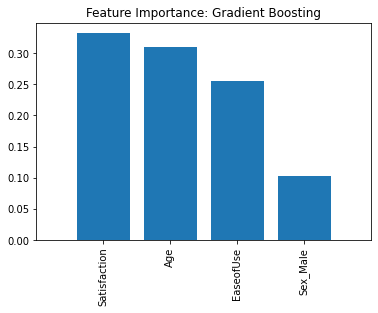

In [46]:
# Feature Selection: Using a Gradient Boosting Classifier:
gbc = GradientBoostingClassifier(criterion='mse', max_depth=89, min_samples_split=7, min_samples_leaf=9, n_estimators=159, 
                            random_state=0)
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test)
feat_labels = df.columns[:-1]
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Gradient Boosting')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### XGBoost Classifier
XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm designed to be highly efficient, flexible and portable.

In [ ]:
# Model: XGBClassifier [cross-validated and standardization of train set]
xgb_cv = XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=1, random_state=0, n_jobs=1)
xgb_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options:
param_dist_xgb = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "learning_rate": np.random.uniform(0,1,10),
                  "objective": ['binary:logistic','reg:linear'],
                  "booster": ['gbtree','gblinear']}
random_search = RandomizedSearchCV(estimator=xgb_cv, param_distributions=param_dist_xgb,
                                   random_state=0, n_iter=100, cv=4)
random_search_xgb = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])
print('Best booster:', random_search_xgb.best_estimator_.get_params()['booster'])


Best n_estimators: 63
Best max_depth: 45
Best learning_rate: 0.9707161877673031
Best objective: multi:softprob
Best booster: gbtree


 1) Satisfaction                   0.287248
 2) EaseofUse                      0.252757
 3) Age                            0.230583
 4) Sex_Male                       0.229411


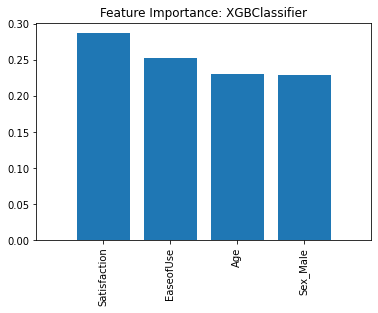

In [47]:
# Model prediction using a XGBClassifier: hold-out test set:  
xgb = XGBClassifier(n_estimators=63, learning_rate=0.97, max_depth=45, objective="multi:softprob",  random_state=0)
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
feat_labels = df.columns[:-1]
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: XGBClassifier')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### Extra Trees Classifier
The predictions of the trees are aggregated to yield the final prediction, by majority vote in classification problems and arithmetic average in regression problems.


In [ ]:
# Model: XGBClassifier [cross-validated and standardization of train set]
etc_cv = ExtraTreesClassifier(n_estimators=50, criterion='gini', max_depth=1, random_state=0, n_jobs=1)
etc_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options:
param_dist_etc = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "criterion": ['gini', 'entropy'],
                  "bootstrap": ['True','False']}
random_search = RandomizedSearchCV(estimator=etc_cv, param_distributions=param_dist_etc,
                                   random_state=0, n_iter=100, cv=4)
random_search_etc = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_etc.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_etc.best_estimator_.get_params()['max_depth'])
print('Best criterion:', random_search_etc.best_estimator_.get_params()['criterion'])
print('Best min_samples_split:', random_search_etc.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_etc.best_estimator_.get_params()['min_samples_leaf'])


 1) Age                            0.348117
 2) Satisfaction                   0.318980
 3) EaseofUse                      0.216653
 4) Sex_Male                       0.116251


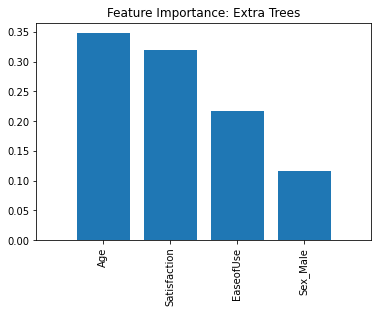

In [48]:
# Feature Selection: Using a Extra Trees Classifier:
etc = ExtraTreesClassifier(n_estimators=72, max_depth=55, criterion= 'entropy', min_samples_split=7, min_samples_leaf=9,random_state=0)
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test)
feat_labels = df.columns[:-1]
importances = etc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Extra Trees')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### Bagging Classifier
In bagging classifier the algorithm builds multiple models from randomly taken subsets of train dataset and aggregates learners to build overall stronger learner.

In [ ]:
# Model: XGBClassifier [cross-validated and standardization of train set]
bag_cv = BaggingClassifier(n_estimators=50, max_samples=1.0, max_features=1.0, random_state=0, n_jobs=1)
bag_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options:
param_dist_bag = {"n_estimators": randint(20, 200), 
                 "max_features": randint(1, 100),
                  "max_samples": randint(1, 10),
                  "bootstrap":[True, False]
                  }
random_search = RandomizedSearchCV(estimator=bag_cv, param_distributions=param_dist_bag,
                                   random_state=0, n_iter=100, cv=4)
random_search_bag = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_bag.best_estimator_.get_params()['n_estimators'])
print('Best max_features:', random_search_bag.best_estimator_.get_params()['max_features'])
print('Best max_samples:', random_search_bag.best_estimator_.get_params()['max_samples'])
print('Best bootstrap:', random_search_bag.best_estimator_.get_params()['bootstrap'])


In [49]:
bag =  BaggingClassifier(n_estimators=83,  max_features=1.0, random_state=0, bootstrap= True)
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test)
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_bag_pred)
print('BaggingClassifier Result')
print(sk_report)
print('roc_auc_score of BaggingClassifier is: '+str(multiclass_roc_auc_score(y_test, y_bag_pred)))

BaggingClassifier Result
              precision    recall  f1-score   support

           0      0.439     0.238     0.308       496
           1      0.388     0.295     0.335       498
           2      0.362     0.476     0.411       498
           3      0.443     0.612     0.514       497

    accuracy                          0.405      1989
   macro avg      0.408     0.405     0.392      1989
weighted avg      0.408     0.405     0.392      1989

roc_auc_score of BaggingClassifier is: 0.6034422171471321


## Majority Vote Classifier (Ensemble Learning)

In [50]:
names = ["LogisticRegression","Support Vector Machine","Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "Extra Tree", "KNeighbors", "Bagging"]

classifiers = [
     LogisticRegression(C=46,penalty='l2',random_state=0),          
    SVC(C=94, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, random_state=0),
    DecisionTreeClassifier(criterion='entropy', max_depth=51, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=19,
                               random_state=0),
    RandomForestClassifier(criterion='entropy', max_depth=33, min_samples_split=6, min_samples_leaf=2, n_estimators=120, 
                            bootstrap= True,random_state=0),
    KNeighborsClassifier(3),
    GradientBoostingClassifier(criterion='mse', max_depth=89, min_samples_split=7, min_samples_leaf=9, n_estimators=159, 
                            random_state=0),
    XGBClassifier(n_estimators=107, learning_rate=0.33, max_depth=49, objective="multi:softprob",  random_state=0),
    ExtraTreesClassifier(n_estimators=72, max_depth=55, criterion= 'entropy', min_samples_split=7, min_samples_leaf=9,random_state=0),
    BaggingClassifier(n_estimators=83,  max_features=1.0, random_state=0, bootstrap= True)
    ]

res = []
res2 = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    res.append(clf.predict(X_test))
    temp = clf.predict(X_train)
    res2.append(temp)
    print(name, " accuracy is : ", accuracy_score(y_train, temp))
    
    
# res.append(res1)

LogisticRegression  accuracy is :  0.33601609657947684
Support Vector Machine  accuracy is :  0.43326626425217973
Decision Tree  accuracy is :  0.3670355466130114
Random Forest  accuracy is :  0.4520456069751844
Gradient Boosting  accuracy is :  0.375083836351442
XGBoost  accuracy is :  0.45288397048960427
Extra Tree  accuracy is :  0.45288397048960427
KNeighbors  accuracy is :  0.43594902749832326
Bagging  accuracy is :  0.45288397048960427


# Evaluation of Model using Confusion Matrix
Confusion matix is one of the methods to evaluate the performance of a classifies and it a tabular summay of classifiers with their corresponding number of correct and incorrrect predictions. 
Since we already knew the accuracy of each model, we'll draw the confusion matrix of selected models.

In [51]:
#Confussion matrix plotting function
def plot_cm (cm, classes):
  fig, ax = plt.subplots(figsize=(10,10))
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_labels, yticklabels=class_labels)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')   
    
class_labels=np.array(['gabapentin','oxycodone','neurontin','lyrica'],dtype=str)

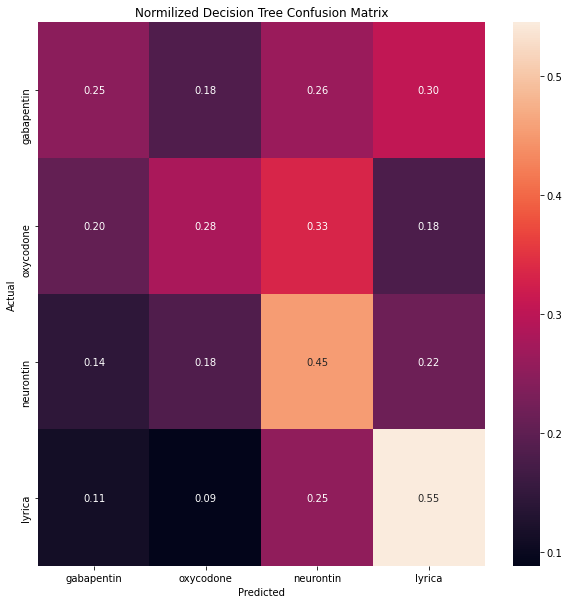

Support vector Machine
              precision    recall  f1-score   support

  gabapentin      0.348     0.248     0.290       496
   oxycodone      0.381     0.281     0.324       498
   neurontin      0.348     0.454     0.394       498
      lyrica      0.437     0.545     0.485       497

    accuracy                          0.382      1989
   macro avg      0.379     0.382     0.373      1989
weighted avg      0.379     0.382     0.373      1989

ROC score of Support vector Machine is 0.59


In [52]:
# Confusion matrix of Support vector Machine
cm=confusion_matrix(y_test, y_svm_pred)
plot_cm(cm, class_labels)
plt.title('Normilized Decision Tree Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_svm_pred,target_names=class_labels)
print('Support vector Machine')
print(sk_report)
print('ROC score of Support vector Machine is %0.2f'% (multiclass_roc_auc_score(y_test, y_svm_pred)))


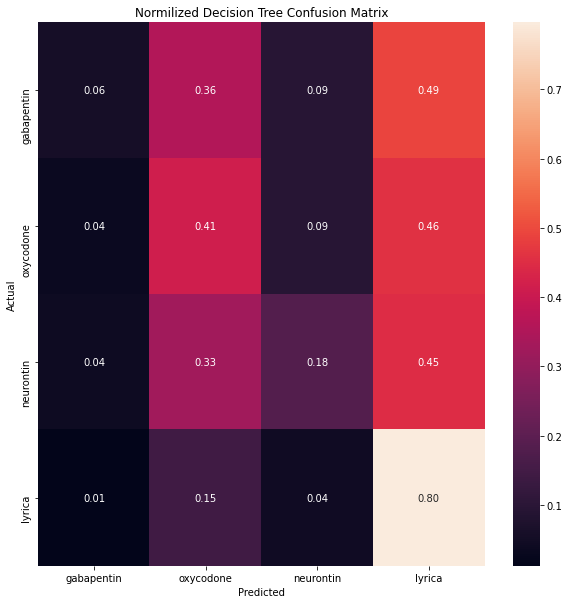

Decision Tree Result
              precision    recall  f1-score   support

  gabapentin      0.389     0.056     0.099       496
   oxycodone      0.333     0.414     0.369       498
   neurontin      0.442     0.183     0.259       498
      lyrica      0.363     0.797     0.498       497

    accuracy                          0.362      1989
   macro avg      0.382     0.362     0.306      1989
weighted avg      0.382     0.362     0.306      1989

ROC score of Decision Tree is 0.57


In [53]:
# Confusion matrix of Decision Tree
cm=confusion_matrix(y_test, y_tree_pred)
plot_cm(cm, class_labels)
plt.title('Normilized Decision Tree Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_tree_pred,target_names=class_labels)
print('Decision Tree Result')
print(sk_report)
print('ROC score of Decision Tree is %0.2f'% (multiclass_roc_auc_score(y_test, y_tree_pred)))


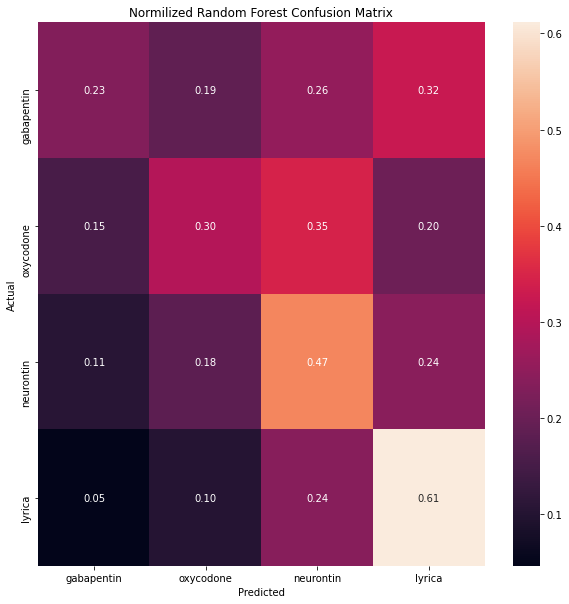

Random Forest Result
              precision    recall  f1-score   support

  gabapentin      0.433     0.234     0.304       496
   oxycodone      0.387     0.297     0.336       498
   neurontin      0.359     0.470     0.407       498
      lyrica      0.443     0.612     0.514       497

    accuracy                          0.403      1989
   macro avg      0.405     0.403     0.390      1989
weighted avg      0.405     0.403     0.390      1989

ROC score of Random Forest is 0.60


In [54]:
# Confusion matrix of Random Forest
cm=confusion_matrix(y_test, y_rf_pred)
plot_cm(cm, class_labels)
plt.title('Normilized Random Forest Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_rf_pred,target_names=class_labels)
print('Random Forest Result')
print(sk_report)
print('ROC score of Random Forest is %0.2f'% (multiclass_roc_auc_score(y_test, y_rf_pred)))


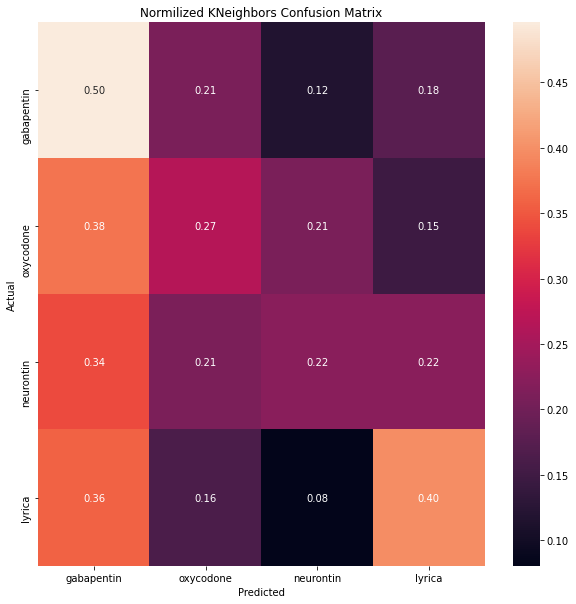

KNeighbors Result
              precision    recall  f1-score   support

  gabapentin      0.315     0.496     0.386       496
   oxycodone      0.314     0.267     0.289       498
   neurontin      0.357     0.225     0.276       498
      lyrica      0.419     0.398     0.409       497

    accuracy                          0.346      1989
   macro avg      0.351     0.347     0.340      1989
weighted avg      0.351     0.346     0.340      1989

ROC score of KNeighbors is 0.56


In [55]:
 # Confusion matrix of KNeighbors
cm=confusion_matrix(y_test, y_knn_pred)
plot_cm(cm, class_labels)
plt.title('Normilized KNeighbors Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_knn_pred,target_names=class_labels)
print('KNeighbors Result')
print(sk_report)
print('ROC score of KNeighbors is %0.2f'% (multiclass_roc_auc_score(y_test, y_knn_pred)))


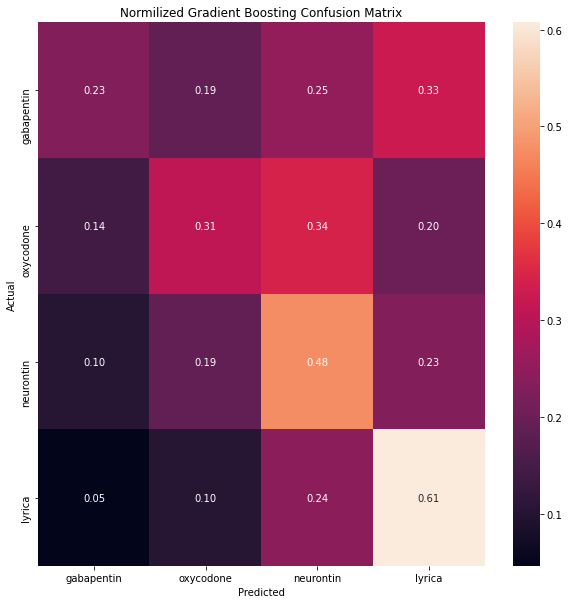

Gradient Boosting Result
              precision    recall  f1-score   support

  gabapentin      0.439     0.232     0.303       496
   oxycodone      0.393     0.311     0.348       498
   neurontin      0.362     0.476     0.411       498
      lyrica      0.445     0.608     0.514       497

    accuracy                          0.407      1989
   macro avg      0.410     0.407     0.394      1989
weighted avg      0.410     0.407     0.394      1989

ROC score of Gradient Boosting is 0.60


In [56]:
# Confusion matrix of Gradient Boosting
cm=confusion_matrix(y_test, y_gbc_pred)
plot_cm(cm, class_labels)
plt.title('Normilized Gradient Boosting Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_gbc_pred,target_names=class_labels)
print('Gradient Boosting Result')
print(sk_report)
print('ROC score of Gradient Boosting is %0.2f'% (multiclass_roc_auc_score(y_test, y_gbc_pred)))


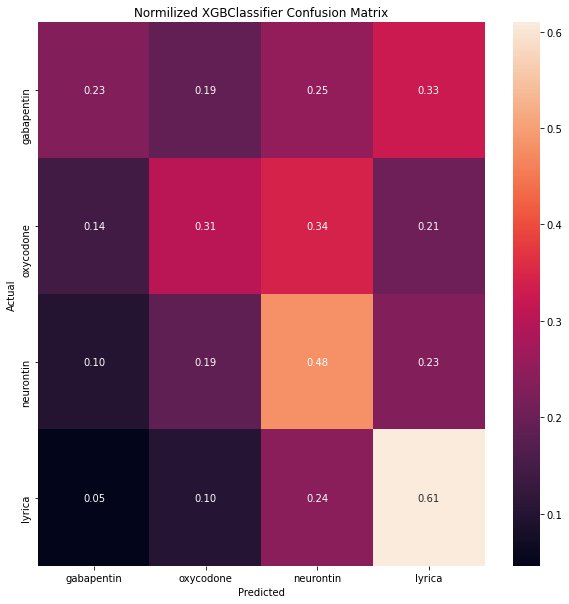

XGBClassifier Result
              precision    recall  f1-score   support

  gabapentin      0.442     0.232     0.304       496
   oxycodone      0.391     0.305     0.343       498
   neurontin      0.364     0.480     0.414       498
      lyrica      0.443     0.610     0.513       497

    accuracy                          0.407      1989
   macro avg      0.410     0.407     0.394      1989
weighted avg      0.410     0.407     0.394      1989

ROC score of XGBClassifier is 0.60


In [57]:
# Confusion matrix of XGBClassifier
cm=confusion_matrix(y_test, y_xgb_pred)
plot_cm(cm, class_labels)
plt.title('Normilized XGBClassifier Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_xgb_pred,target_names=class_labels)
print('XGBClassifier Result')
print(sk_report)
print('ROC score of XGBClassifier is %0.2f'% (multiclass_roc_auc_score(y_test, y_xgb_pred)))


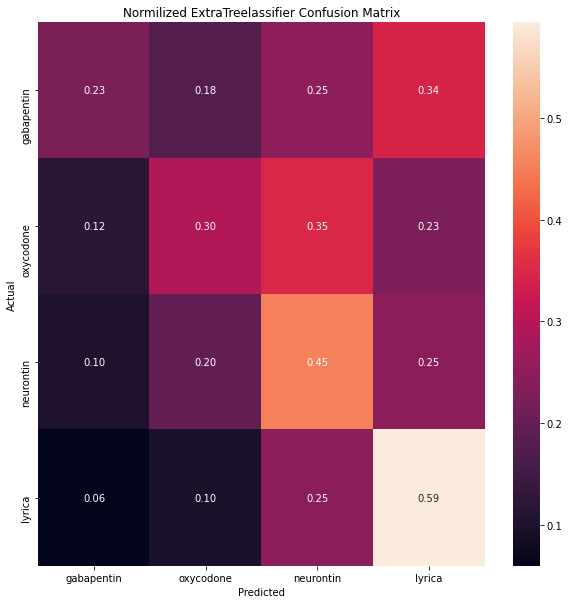

ExtraTreelassifier Result
              precision    recall  f1-score   support

  gabapentin      0.443     0.228     0.301       496
   oxycodone      0.386     0.295     0.334       498
   neurontin      0.348     0.454     0.394       498
      lyrica      0.419     0.594     0.491       497

    accuracy                          0.393      1989
   macro avg      0.399     0.393     0.380      1989
weighted avg      0.399     0.393     0.380      1989

ROC score of ExtraTreelassifier is 0.60


In [58]:
# Confusion matrix of ExtraTreelassifier
cm=confusion_matrix(y_test, y_etc_pred)
plot_cm(cm, class_labels)
plt.title('Normilized ExtraTreelassifier Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_etc_pred,target_names=class_labels)
print('ExtraTreelassifier Result')
print(sk_report)
print('ROC score of ExtraTreelassifier is %0.2f'% (multiclass_roc_auc_score(y_test, y_etc_pred)))


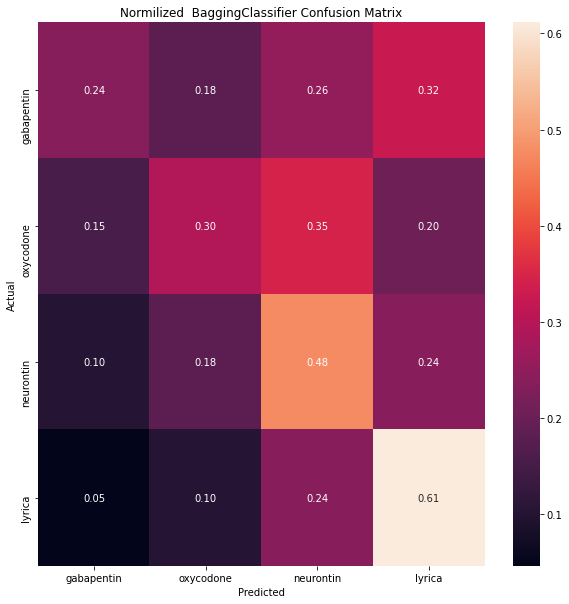

 BaggingClassifier Result
              precision    recall  f1-score   support

  gabapentin      0.439     0.238     0.308       496
   oxycodone      0.388     0.295     0.335       498
   neurontin      0.362     0.476     0.411       498
      lyrica      0.443     0.612     0.514       497

    accuracy                          0.405      1989
   macro avg      0.408     0.405     0.392      1989
weighted avg      0.408     0.405     0.392      1989

ROC score of  BaggingClassifier is 0.60


In [60]:
# Confusion matrix of  BaggingClassifier
cm=confusion_matrix(y_test, y_bag_pred)
plot_cm(cm, class_labels)
plt.title('Normilized  BaggingClassifier Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_bag_pred,target_names=class_labels)
print(' BaggingClassifier Result')
print(sk_report)
print('ROC score of  BaggingClassifier is %0.2f'% (multiclass_roc_auc_score(y_test, y_bag_pred)))


# Evaluation of Model using precision-recall curve

In [67]:
# Create ROC Graph
#https://stackoverflow.com/questions/59666138/sklearn-roc-auc-score-with-multi-class-ovr-should-have-none-average-available
#(reference for ROC)
rf_ev, rf_evn, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
xgb_ev, xgb_evn, xgb_thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
xgb_ev, xgb_evn, xgb_thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.figure()

# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)

# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)

# Plot XGBClassifier ROC
plt.plot(xbc_ev, xbc_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

In [64]:
def multiclass_roc_auc_score(y_test,y_pred,average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test=lb.transform(y_test)
  y_pred=lb.transform(y_pred)
  return roc_auc_score(y_test,y_pred,average=average)

In [65]:
# Create ROC Graph
#https://stackoverflow.com/questions/59666138/sklearn-roc-auc-score-with-multi-class-ovr-should-have-none-average-available
#(reference for ROC)
rf_ev, rf_evn, rf_thresholds = multiclass_roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
xgb_ev, xgb_evn, xgb_thresholds = multiclass_roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = multiclass_roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = multiclass_roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])
xgb_ev, xgb_evn, xgb_thresholds = multiclass_roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

plt.figure()

# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)

# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)

# Plot XGBClassifier ROC
plt.plot(xbc_ev, xbc_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

In [68]:
def multiclass_roc_auc_score(y_test,y_pred,average="macro"):
  lb = preprocessing.MultiLabelBinarizer()
  lb.fit(y_test)
  y_test=lb.transform(y_test)
  y_pred=lb.transform(y_pred)
  return roc_auc_score(y_test,y_pred,average=average)
  

In [69]:
# Create ROC Graph
#https://stackoverflow.com/questions/59666138/sklearn-roc-auc-score-with-multi-class-ovr-should-have-none-average-available
#(reference for ROC)
rf_ev, rf_evn, rf_thresholds = multiclass_roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
xgb_ev, xgb_evn, xgb_thresholds = multiclass_roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = multiclass_roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = multiclass_roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])
xgb_ev, xgb_evn, xgb_thresholds = multiclass_roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

plt.figure()

# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)

# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)

# Plot XGBClassifier ROC
plt.plot(xbc_ev, xbc_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

TypeError: ignored

In [66]:
y_score_dt = etc.fit(X_train,y_train).predict_proba(X_test)[:,1]
avg_precision = multiclass_roc_auc_score(y_test, y_score_dt)

print('Average precision-recall score of Etra tree model: {0:0.2f}'.format(
      avg_precision))

# Plot Precision-Recall curve:
###############################################################################
precision, recall, _ = multiclass_roc_auc_score(y_test_enc, y_score_dt)

sns.set_style('whitegrid')

plt.step(recall, precision, color='navy', where='post',label='Precision-Recall curve')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='navy')
plt.title('Precision-Recall curve: Decission Tree [test set] AP={0:0.2f}'
          .format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

ValueError: ignored

# Practical Utilization of Model

After modeling

In [ ]:
# https://stackoverflow.com/questions/58250823/add-filters-to-scatter-plot-based-on-a-pandas-dataframe